# Assessment: Weekly deliverable template - Classification
<font color='#AC135A'>**Applied Machine Learning** - **Sheffield Hallam University**</font>


---

## Introduction
Add your solutions to the different sub-tasks requested for this deliverable.

<font color='red'>DO NOT ADD MORE CELLS TO THE FINAL VERSION OF THIS NOTEBOOK.

### 1. Dataset loading

In [ ]:
import matplotlib.pyplot as plt   
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  
from sklearn.cluster import KMeans  
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import make_pipeline
from itertools import combinations
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


In [119]:
# Loading and pre-processing the data as in the week 3 assessment

df = pd.read_csv('wines_SPA.csv')

df = df.drop_duplicates()

# Removing columns I do not want to further use.
df = df.drop(columns=['country', 'acidity'], axis=1)

# Drop missing values and drop duplicates again
df = df.dropna()

# Engineering features

# Price
df['price_log'] = np.log(df['price'])

# Year
# First, convert year into a numeric column, all strings will be NaN
df['year_numeric'] = pd.to_numeric(df['year'], errors='coerce') 
# Add a column to indicate missing values
df['is_nv'] = (df['year_numeric'].isna()).astype(int) 
# Get the median year for imputing
median_year = df['year_numeric'].median()
# impute
df['year_numeric'] = df['year_numeric'].fillna(median_year)
# calculate age
df['age'] = df['year_numeric'].max() + 1 - df['year_numeric']
# calculate log of age
df['age_log'] = np.log(df['age'])


# For categorical variables, only keep those with at least 175 occurrences (10% of all examples), others as 'Other'

# find unique values and their counts in categorical columns 
type_counts = df['type'].value_counts()
winery_counts = df['winery'].value_counts()
wine_counts = df['wine'].value_counts()
region_counts = df['region'].value_counts()

# from each remove the ones with less than 175 occurrences
type_to_keep = type_counts[type_counts >= 175].index
winery_to_keep = winery_counts[winery_counts >= 175].index
wine_to_keep = wine_counts[wine_counts >= 175].index
region_to_keep = region_counts[region_counts >= 175].index

# Create a new type column with only the frequent types, others as 'Other'
df['type_r'] = df['type'].where(df['type'].isin(type_to_keep), 'Other')
df['winery_r'] = df['winery'].where(df['winery'].isin(winery_to_keep), 'Other')
df['wine_r'] = df['wine'].where(df['wine'].isin(wine_to_keep), 'Other')
df['region_r'] = df['region'].where(df['region'].isin(region_to_keep), 'Other')           

# One-hot encode categorical variables leaving out the first category to avoid multicollinearity
type_dummies = pd.get_dummies(df['type_r'], prefix='type', drop_first=True)
winery_dummies = pd.get_dummies(df['winery_r'], prefix='winery', drop_first=True)
wine_dummies = pd.get_dummies(df['wine_r'], prefix='wine', drop_first=True)
region_dummies = pd.get_dummies(df['region_r'], prefix='region', drop_first=True)
# Concatenate the new dummy columns to the original dataframe
df = pd.concat([df, type_dummies, winery_dummies, wine_dummies, region_dummies], axis=1)
# save the dummy column names
type_columns = type_dummies.columns.tolist()    
winery_columns = winery_dummies.columns.tolist()
wine_columns = wine_dummies.columns.tolist()
region_columns = region_dummies.columns.tolist()




**Observations:**  

I only drop 'country' and 'acidity' this time, as they do not have any informational content. I keep add num_reviews, because maybe it is interesting for descriptive clustering. (As discussed in the last assessment, it is not suitable for predicting.) 

Also, I do include 'wine', 'winery' and 'region' this time as it maybe be interesting for clustering. However, I only keeo the values that occur at least in 10% of all examples (175 or more), while summarising the others as 'Others' as I assume that those features wouldn't be stable. (I don't know if the 10% is a good value, but it seems if there are not enough examples, the training is probably not very meaningful. So these 10% are an arbitrary value. I am curious to know if there is a way to determine what a good value would be.) 

### 1a. Feature set selection with SFS

In [120]:
# I am now determining which features are actually the most relevant for determining the quality of a wine
# using Sequential Forward Selection (SFS) with a linear regression model and 5-fold cross-validation
# I will use Mean Absolute Error (MAE) and R2 as the performance metric.    
# Raschka et al. (2022). Machine Learning with Python and Scikit-Learn. Packt Publishing. p. 128ff.

# Define the feature set and target variable
feature_columns = ['price_log', 'age_log', 'is_nv', 'body'] + type_columns + winery_columns + wine_columns + region_columns
X = df[feature_columns]
y = df['rating']
# Initialize the linear regression model

pipe = make_pipeline(StandardScaler(), LinearRegression())

# MAE
# Initialize the Sequential Forward Selector
sfs = SFS(pipe, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='neg_mean_absolute_error', 
          cv=5, 
          n_jobs=-1)
# Perform SFS
sfs = sfs.fit(X, y)
# Get the selected features
selected_features = list(sfs.k_feature_names_)
print("Selected features (MAE):", selected_features)
# Get the performance of the selected feature set
print("CV MAE of selected features:", -sfs.k_score_)    

# R2
# Initialize the Sequential Forward Selector
sfs = SFS(pipe, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='r2', 
          cv=5, 
          n_jobs=-1)
# Perform SFS
sfs = sfs.fit(X, y)
# Get the selected features
selected_features = list(sfs.k_feature_names_)
print("Selected features (R2):", selected_features)
# Get the performance of the selected feature set
print("CV R2 of selected features:", -sfs.k_score_)    




0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Selected features (MAE): ['price_log', 'age_log', 'is_nv', 'region_Priorato', 'region_Ribera del Duero', 'region_Rioja']
CV MAE of selected features: 0.11362899125990907
Selected features (R2): ['price_log', 'age_log', 'is_nv', 'type_Priorat Red', 'region_Priorato', 'region_Ribera del Duero', 'region_Rioja']
CV R2 of selected features: 80.66662996453142



**Observation:**

When I compare these results with the results from week 3 assessment, I see that "the best" MAE is actually higher at 0.11 compared with 0.084 with the features ['price_log', 'age_log', 'is_nv', 'body'] + type_columns. However, I did not do CV back then, so maybe that result was accidental. 

The R2 on the other hand is much better compared to week 3, when it was only around 50%. with the feature set ['price_log', 'age_log', 'is_nv', 'type_Priorat Red', 'region_Priorato', 'region_Ribera del Duero', 'region_Rioja'] 81% of the rating variance can be explained. 

I am only doing this exercise to decide on a number of feature combinations for the clustering (rather than being arbitrary or try literally every combination). As I want to see if unsupervised training gives me classes that correlate to rating in any way, I use rating as 


In [121]:
# I will now create some exemplatory feature sets based on these results which I will use for clustering:
# all features
feature_columns_all = ['price_log', 'age_log', 'is_nv','body'] + type_columns + winery_columns + wine_columns + region_columns
# selected features from SFS (MAE)
feature_columns_sfs_mae = ['price_log', 'age_log', 'is_nv', 'region_Priorato', 'region_Ribera del Duero', 'region_Rioja']
# selected features from SFS (R2)
feature_columns_sfs_r2 = ['price_log', 'age_log', 'is_nv', 'type_Priorat Red', 'region_Priorato', 'region_Ribera del Duero', 'region_Rioja']
# Minimal feature set (based on the analysis in the previous assessment
feature_columns_minimal = ['price_log', 'age_log']

I also want to understand which features I need to use to get the best seperated clustering given a target number of clusters. I will try all combinations, just out of curiosity. 
Executing this takes some time!

In [122]:
# CAREFUL: The clustering with all features takes a long time to compute, so be patient or reduce the feature set!


X = df[feature_columns_all].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_indices = range(X.shape[1])
cluster_range = range(2, 11)

# I want to find the best feature sets for each number of clusters
for k in cluster_range:
    best_score = -1
    best_k = None
    best_features = None
    # For each number of features
    for r in range(1, len(feature_indices) + 1):
        # Try all combinations of features
        for subset in combinations(feature_indices, r):
            X_subset = X_scaled[:, subset]
            model = KMeans(n_clusters=k, random_state=42)
            # Remove duplicates
            X_unique = np.unique(X_subset, axis=0)
            # Ensure there are enough unique points for k clusters
            if len(X_unique) < k:
                continue
            # Get the labels
            labels = model.fit_predict(X_unique)
            # Ensure there are enough labels to compute silhouette score
            n_labels = len(np.unique(labels))
            if len(X_unique) < 2 or n_labels >= len(X_unique):
                continue
            score = silhouette_score(X_unique, labels)
            if score > best_score:
                best_score = score
                best_k = k
                best_features = subset

   
    print(f"\nNumber of clusters: {best_k}")
    print(f"Best silhouette score: {best_score}")
    features = [feature_columns_all[i] for i in best_features]
    print(f"Best feature subset: {features}")


Number of clusters: 2
Best silhouette score: 0.7911081092926001
Best feature subset: ['price_log', 'is_nv']

Number of clusters: 3
Best silhouette score: 0.7429923548904095
Best feature subset: ['price_log', 'is_nv', 'type_Priorat Red', 'region_Priorato']

Number of clusters: 4
Best silhouette score: 0.6864401178150341
Best feature subset: ['price_log', 'type_Priorat Red', 'type_Red', 'type_Ribera Del Duero Red', 'region_Priorato', 'region_Ribera del Duero']

Number of clusters: 5
Best silhouette score: 0.6846281302206111
Best feature subset: ['price_log', 'type_Priorat Red', 'type_Red', 'type_Ribera Del Duero Red', 'region_Priorato', 'region_Ribera del Duero']

Number of clusters: 6
Best silhouette score: 0.6904640258740303
Best feature subset: ['price_log', 'is_nv', 'type_Priorat Red', 'type_Red', 'type_Ribera Del Duero Red', 'region_Priorato', 'region_Ribera del Duero']

Number of clusters: 7
Best silhouette score: 0.6652591752467313
Best feature subset: ['price_log', 'is_nv', 'typ

**Observation**

What is immediately interesting is that none of the feature sets that give the cleanest clusterings include "age_log".

However, I wonder how meaningful it is to select features simply based on best cluster separatability. I would expect that clustering by boolean features is generally better (because there are only two values). I guess one continuous feature may be ok to separate (as in price_log), but not multiple, as then the picture may become too complex. 

In [123]:

feature_columns_optimal_6_7_clusters = ['price_log', 'is_nv', 'type_Priorat Red', 'type_Red', 'type_Ribera Del Duero Red', 'region_Priorato', 'region_Ribera del Duero']


### 2. Cluster metrics/comparison table on the data + elbow plots



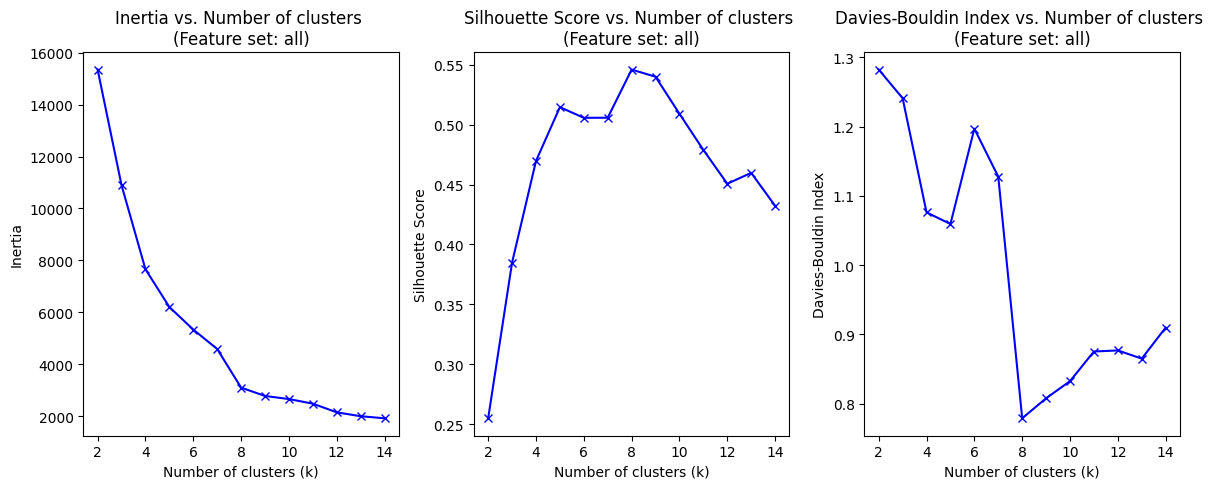

Scores for feature set: all
     k       Inertia  Silhouette Score  Davies-Bouldin Index
0    2  15351.808019          0.254993              1.282257
1    3  10896.383030          0.384925              1.240924
2    4   7657.025983          0.469657              1.076140
3    5   6202.930102          0.514572              1.059460
4    6   5333.375761          0.505674              1.196971
5    7   4585.389356          0.505737              1.127702
6    8   3097.569044          0.545923              0.779081
7    9   2775.534708          0.539916              0.807934
8   10   2656.292768          0.509018              0.832656
9   11   2478.379679          0.478844              0.875425
10  12   2145.119309          0.450662              0.876997
11  13   1995.083884          0.459754              0.865125
12  14   1915.389169          0.432256              0.909928


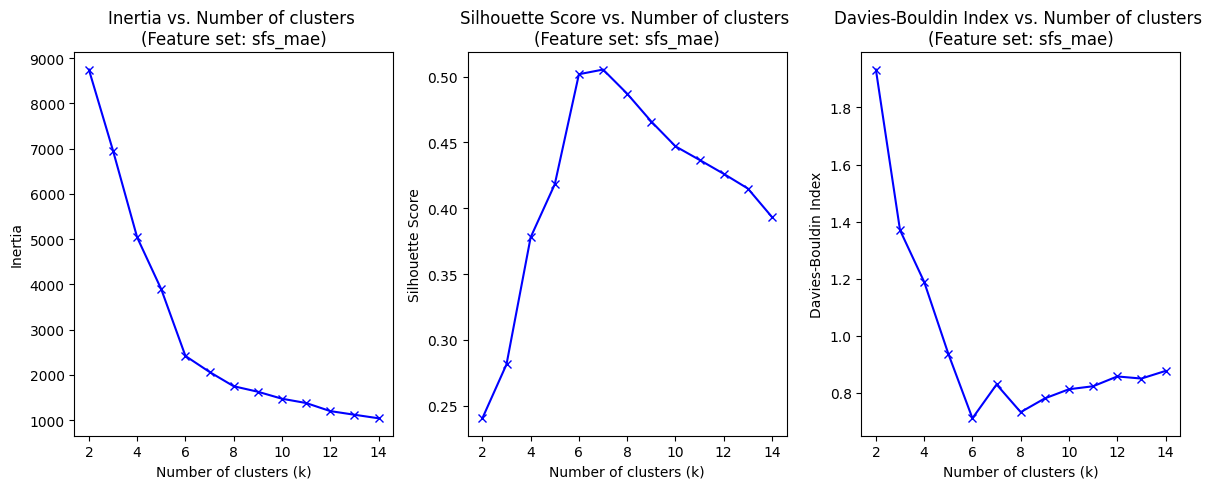

Scores for feature set: sfs_mae
     k      Inertia  Silhouette Score  Davies-Bouldin Index
0    2  8747.970245          0.240502              1.932642
1    3  6954.550712          0.281492              1.370066
2    4  5037.667183          0.377922              1.188922
3    5  3888.956208          0.418222              0.937292
4    6  2415.875257          0.501749              0.710965
5    7  2061.603773          0.505278              0.829459
6    8  1746.337728          0.486941              0.732502
7    9  1625.112147          0.465782              0.780706
8   10  1470.365621          0.446992              0.812745
9   11  1375.672695          0.436659              0.823206
10  12  1196.934778          0.426104              0.857538
11  13  1116.461031          0.414935              0.850177
12  14  1037.898688          0.393282              0.876848


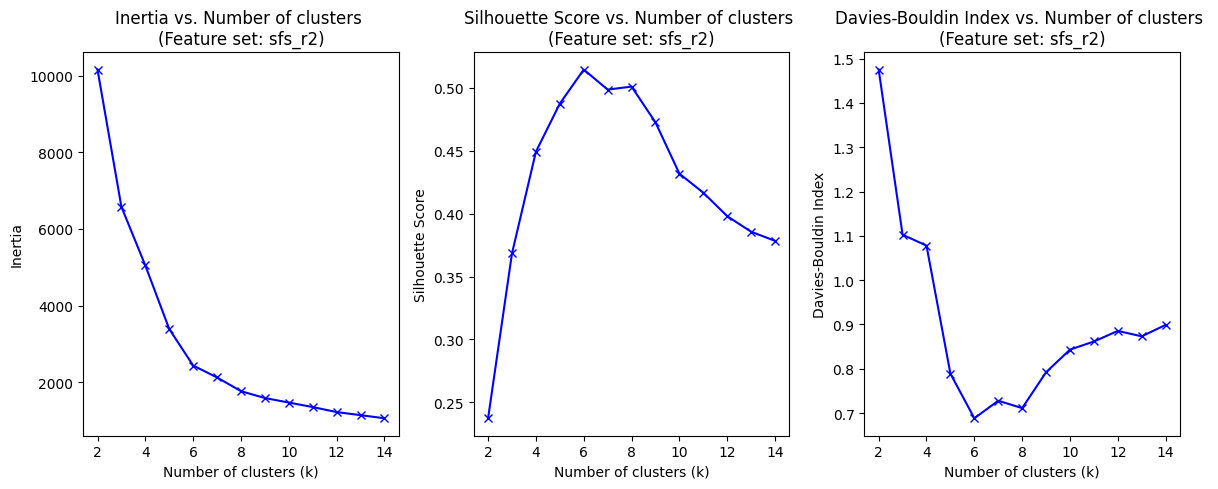

Scores for feature set: sfs_r2
     k       Inertia  Silhouette Score  Davies-Bouldin Index
0    2  10159.187493          0.237272              1.475202
1    3   6575.711874          0.368398              1.102456
2    4   5045.456571          0.449285              1.077904
3    5   3386.652231          0.487531              0.788877
4    6   2433.851812          0.514600              0.688146
5    7   2121.722234          0.498667              0.727775
6    8   1763.960236          0.501055              0.711065
7    9   1585.569303          0.472585              0.792090
8   10   1467.130971          0.431777              0.843102
9   11   1349.753995          0.416667              0.861478
10  12   1218.786882          0.397982              0.885339
11  13   1138.670405          0.385621              0.873113
12  14   1056.887911          0.378369              0.898936


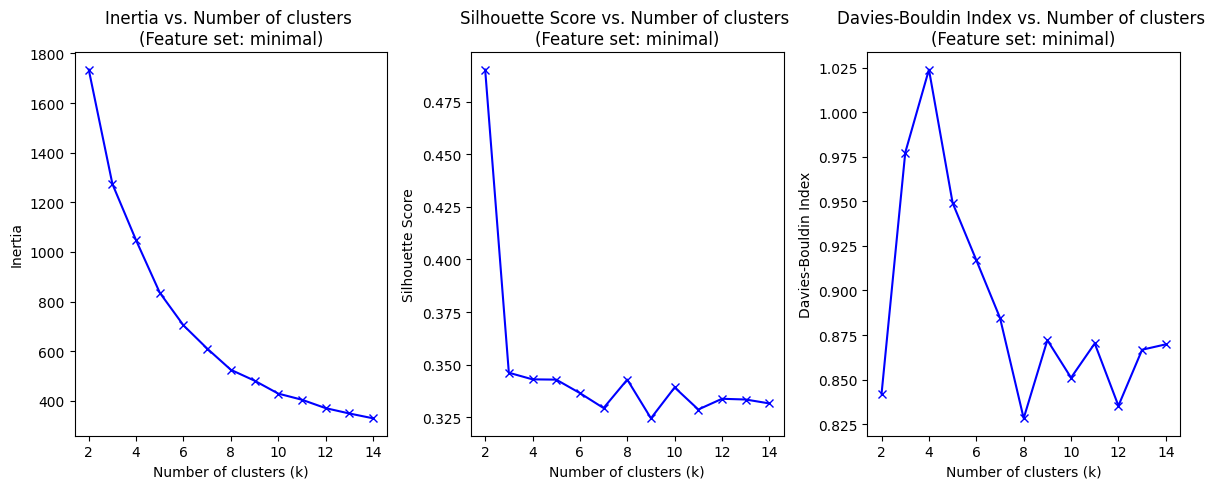

Scores for feature set: minimal
     k      Inertia  Silhouette Score  Davies-Bouldin Index
0    2  1734.833794          0.490219              0.842182
1    3  1273.506368          0.346153              0.977333
2    4  1046.682577          0.343004              1.023898
3    5   835.411652          0.342876              0.949093
4    6   704.011141          0.336480              0.917008
5    7   610.497651          0.329367              0.884635
6    8   524.851139          0.342900              0.828336
7    9   481.098948          0.324502              0.872146
8   10   428.990975          0.339168              0.851088
9   11   404.274758          0.328676              0.870322
10  12   370.410753          0.333769              0.835350
11  13   348.880697          0.333426              0.866782
12  14   329.470021          0.331556              0.869803


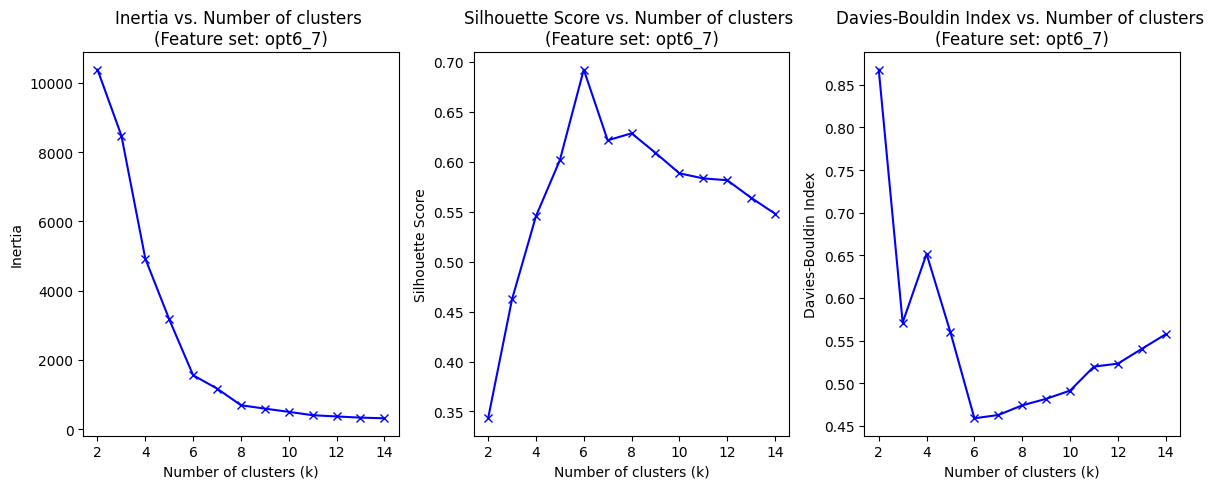

Scores for feature set: opt6_7
     k       Inertia  Silhouette Score  Davies-Bouldin Index
0    2  10380.751723          0.343141              0.867808
1    3   8473.032966          0.462343              0.571121
2    4   4921.624205          0.545500              0.651716
3    5   3170.440594          0.601606              0.559510
4    6   1555.597832          0.692354              0.458870
5    7   1171.149495          0.621518              0.462718
6    8    689.932112          0.628507              0.474043
7    9    591.926130          0.608987              0.481681
8   10    499.171694          0.588453              0.491311
9   11    401.559332          0.583359              0.519479
10  12    365.445642          0.581547              0.522947
11  13    332.170978          0.563945              0.540240
12  14    312.976423          0.548053              0.557363


In [124]:
# I now want to create inertia, silhouette and Davies-Bouldin index plots for KMeans clustering with selected feature sets to determine the optimal number of clusters.
# Also include a table with the inertia, silhouette scores, and Davies-Bouldin index for each k.
# Define feature columns
feature_columns = {
    'all': feature_columns_all,
    'sfs_mae': feature_columns_sfs_mae,
    'sfs_r2': feature_columns_sfs_r2,
    'minimal': feature_columns_minimal,
    'opt6_7': feature_columns_optimal_6_7_clusters
}

for key, cols in feature_columns.items():
    X = df[cols]
    # Scaling the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    inertia = []
    silhouette = []
    davies_bouldin = []
    K = range(2, 15)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(X_scaled, kmeans.labels_))
        davies_bouldin.append(davies_bouldin_score(X_scaled, kmeans.labels_))
        
    
    # Plotting the inertia and silhouette scores
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title(f'Inertia vs. Number of clusters \n(Feature set: {key})')
    
    plt.subplot(1, 3, 2)
    plt.plot(K, silhouette, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs. Number of clusters \n(Feature set: {key})')

    plt.subplot(1, 3, 3)
    plt.plot(K, davies_bouldin, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Davies-Bouldin Index')
    plt.title(f'Davies-Bouldin Index vs. Number of clusters \n(Feature set: {key})')

    plt.tight_layout()
    plt.show()
    # Displaying the inertia and silhouette scores in a table
    scores_df = pd.DataFrame({'k': K, 'Inertia': inertia, 'Silhouette Score': silhouette, 'Davies-Bouldin Index': davies_bouldin})
    print(f'Scores for feature set: {key}')
    print(scores_df)

**Observation:**

The plots show that the inertia elbows, the silhouette score peaks and the Davies-Bouldin troughs are nicely aligned for the different sets of features. 

The minimal feature set shows very poor clustering based on the silhouette score, and I will no longer proceed with it. 

All features (i.e. 11 features) has the best silhouette score at 8 clusters, peaking at close to 0.55.

Both R2 and MAE based features sets (7 and 6 featurers, resp.) have similar results, suggesting 6 and 7 clusters with silhouette scores just above 0.50.

However, for the MAE based feature set, the David Bouldin index is lower for 6 clusters. As the silhouette scores are avery similar for 6 and 7 clusters, I wil go with 6 clusters, as this is also in line with the R2 feature set. 

The optimised feature set shows the expected very high peak at 6 clusters. 

## 3. Clustering with results for different values of the parameters (model selection)

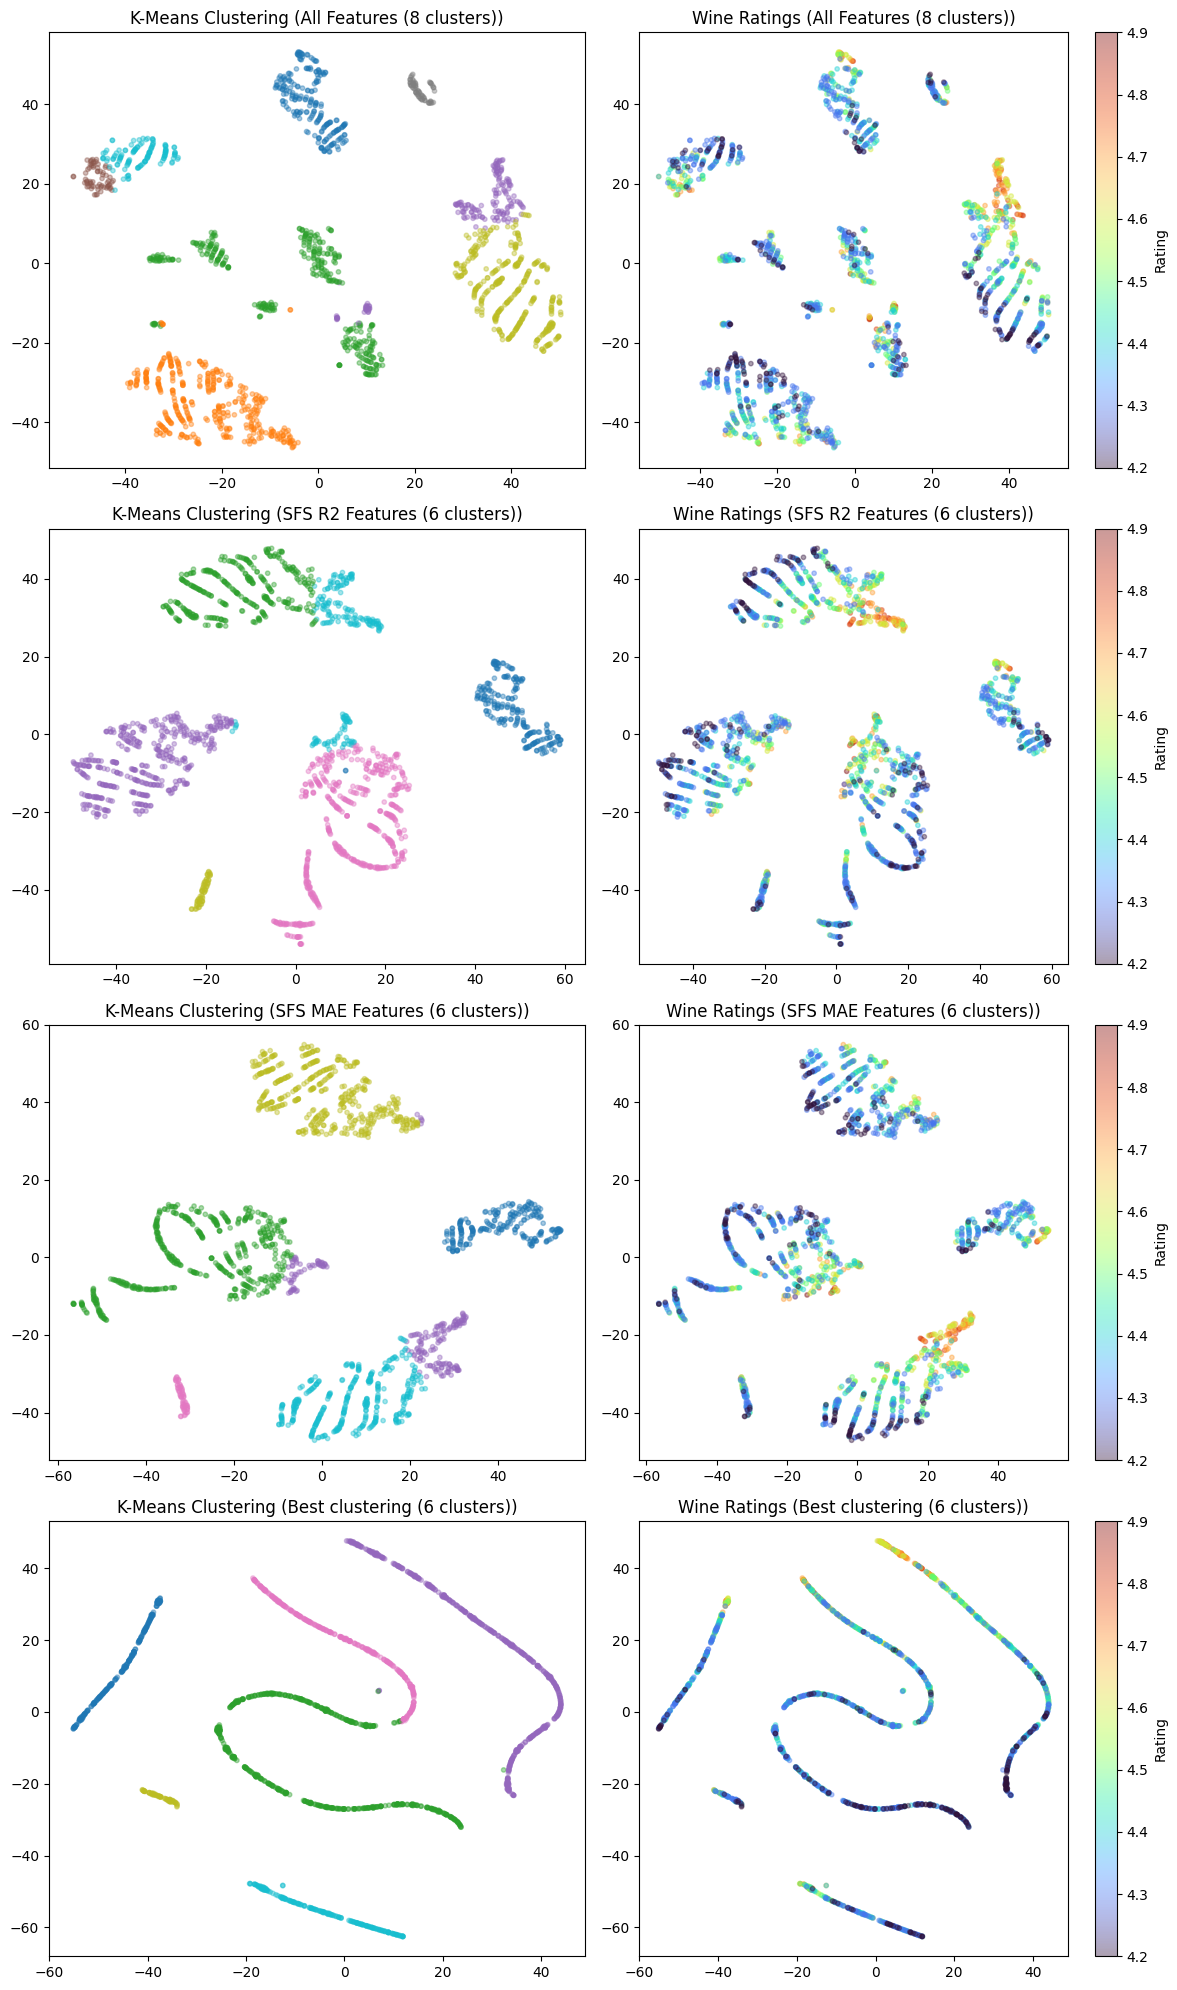

<Figure size 640x480 with 0 Axes>

In [125]:
# Now I want to visualise the three best clustering results based on the silhouette scores above with t-SNE + one example for the "best clustering" experiment 
# I want to see next to each other on the left the clustering labels and on the right another t-SNE visualisation, but colored with the wine ratings.
# I will use 8 clusters for the all features set, 7 clusters for the SFS R2 set and 6 clusters for the SFS MAE set and the best clustering set.

feature_sets = {
    'All Features (8 clusters)': (feature_columns_all, 8),
    'SFS R2 Features (6 clusters)': (feature_columns_sfs_r2, 6),
    'SFS MAE Features (6 clusters)': (feature_columns_sfs_mae, 6),
    'Best clustering (6 clusters)': (feature_columns_optimal_6_7_clusters, 6)
}
# Prepare the figure
fig, axes = plt.subplots(len(feature_sets), 2, figsize=(12, 5 * len(feature_sets)))
axes = axes.flatten()   
# Function to perform k-means clustering and plot the results
for i, (title, (features, n_clusters)) in enumerate(feature_sets.items()):
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    labels = kmeans.fit_predict(X_scaled)
    
    # t-SNE for 2D visualization
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Plot clustering results
    axes[2*i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=10, alpha=0.4)
    axes[2*i].set_title(f'K-Means Clustering ({title})')
    
    # Plot wine ratings
    scatter = axes[2*i + 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['rating'], cmap='turbo', s=10, alpha=0.4)
    axes[2*i + 1].set_title(f'Wine Ratings ({title})')
    fig.colorbar(scatter, ax=axes[2*i + 1], label='Rating')
plt.tight_layout()
plt.show()
# Also add the same plots for hierarchical clustering with the same feature sets and number of clusters
for i, (title, (features, n_clusters)) in enumerate(feature_sets.items()):
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(X_scaled)
    
    # t-SNE for 2D visualization
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Plot clustering results
    axes[2*i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=10, alpha=0.4)
    axes[2*i].set_title(f'Hierarchical Clustering ({title})')
    
    # Plot wine ratings
    scatter = axes[2*i + 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['rating'], cmap='turbo', s=10, alpha=0.4)
    axes[2*i + 1].set_title(f'Wine Ratings ({title})')
    fig.colorbar(scatter, ax=axes[2*i + 1], label='Rating')
plt.tight_layout()
plt.show()
                

**Observation**

I chose t-SNE for visualisation because in my tests it showed the groupings better than PCA. 

Interestingly, in each test there are clearly separated islands in the t-SNE plots, but they do not fully align with the new lables (left side plots.) 

I plotted the same t-SNE visualisation using ratings for colouring on the right hand side as I selected the features based on the rating models. What I see is that the clusters do not match the ratings, but within each island the ratings seem to trend in a certain direction. I wonder if I can interpret this as a consequence of the good regression of the selected features with rating: Closer points should also have closer ratings, even if rating is not a feature. 

Finally, the "best clustering" example at the bottom confirms what I think is a consequence of using mostly binary features: We see lines rather than point clusters. But notably here also I observe the rating trend within each cluster (even though "age_log" is not included!)

 

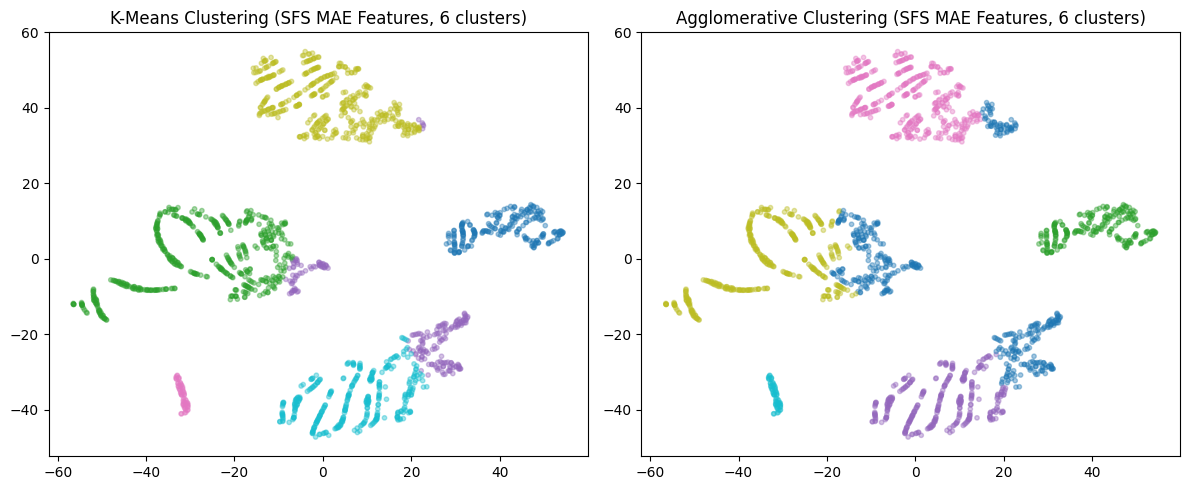

K-Means Silhouette Score: 0.5017490195689086
Agglomerative Silhouette Score: 0.4424447497398899


In [126]:
# Now I will plot the t-SNE visualitions for 6 SFS MAE features and 7 clusters for both agglomerative clustering and KMeans next to each other for comparison.
# Also add the silhouette scores for both methods.
X = df[feature_columns_sfs_mae]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans_labels = kmeans.fit_predict(X_scaled)
model = AgglomerativeClustering(n_clusters=6)
agglo_labels = model.fit_predict(X_scaled)
# t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
# Prepare the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot KMeans clustering results
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='tab10', s=10, alpha=0.4) 
axes[0].set_title('K-Means Clustering (SFS MAE Features, 6 clusters)')
# Plot Agglomerative clustering results
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=agglo_labels, cmap='tab10', s=10, alpha=0.4) 
axes[1].set_title('Agglomerative Clustering (SFS MAE Features, 6 clusters)')
plt.tight_layout()
plt.show()

# Calculate silhouette scores
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
agglo_silhouette = silhouette_score(X_scaled, agglo_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"Agglomerative Silhouette Score: {agglo_silhouette}")





**Observations:**  

There are some differences in the clustering between KMeans and Agglomerative Clustering. However, by and large the clusters are similar in structure. As I do not know what these clusters mean, it is hard for me to decide which ones are better, except by going for the silhouette score, which is higher for K-Means. 

### 4. PCA (variance plot + PC scatter plot)


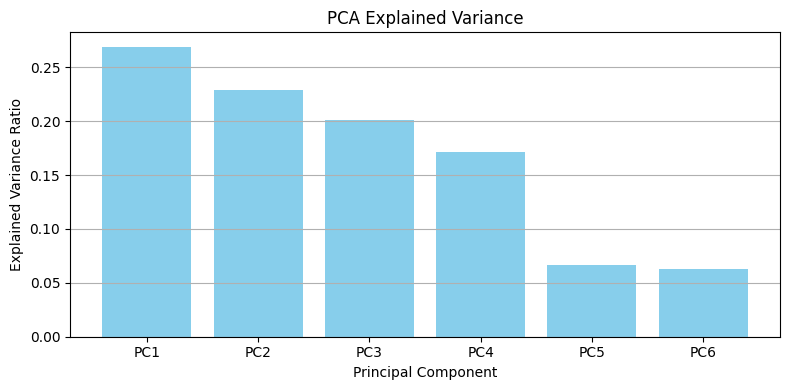

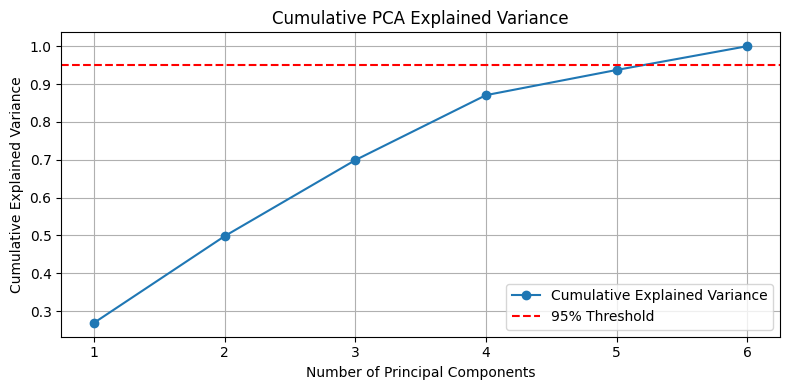

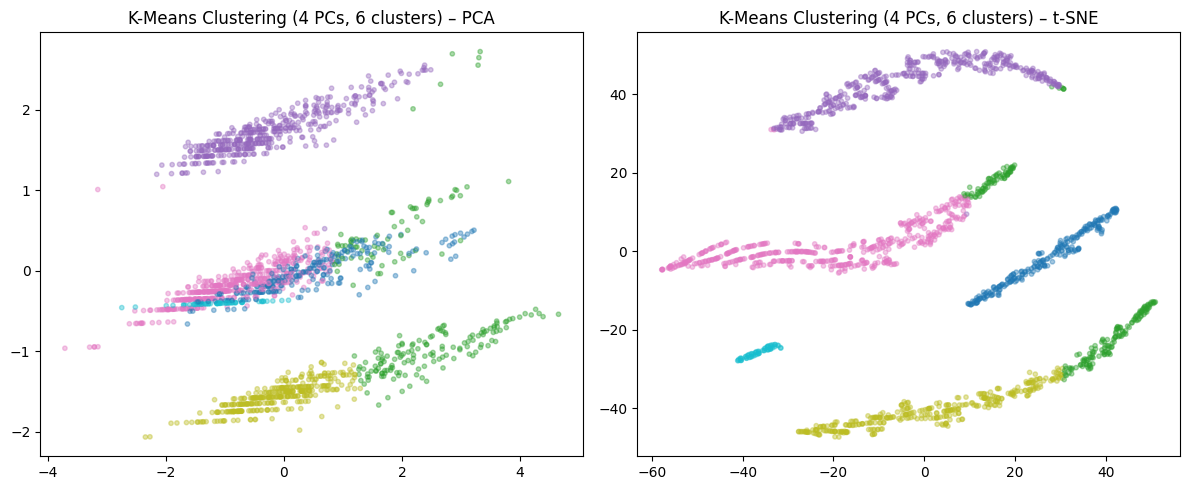

K-Means Silhouette Score (4 PCs): 0.537101397590628


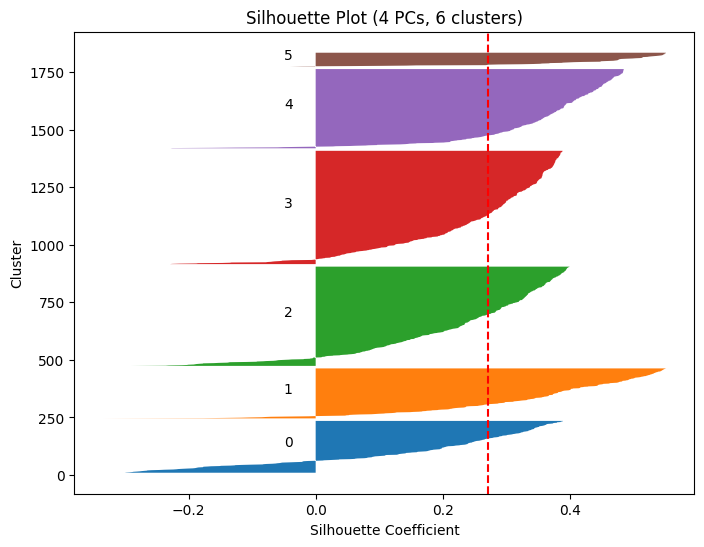

In [127]:
# Fit PCA based on the SFS MAE features.


scaler = StandardScaler()

X = df[feature_columns_sfs_mae]
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)

# Bar plot of explained variance
plt.figure(figsize=(8, 4))
plt.bar(x=np.arange(1, len(pca.explained_variance_ratio_) + 1),
        height=pca.explained_variance_ratio_,
        tick_label=[f'PC{i}' for i in range(1, len(pca.explained_variance_ratio_) + 1)],
        color='skyblue')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')
plt.xticks(range(1, len(cum_var) + 1))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative PCA Explained Variance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Train KMeans on the PCA-transformed data
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans_labels = kmeans.fit_predict(X_pca)


# PCA plot and t-SNE plots with KMeans clustering labels
# Prepare the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot PCA results
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', s=10, alpha=0.4)
axes[0].set_title('K-Means Clustering (4 PCs, 6 clusters) – PCA')
# t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)
# Plot t-SNE results
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='tab10', s=10, alpha=0.4)     
axes[1].set_title('K-Means Clustering (4 PCs, 6 clusters) – t-SNE')
plt.tight_layout()
plt.show()      

# Calculate silhouette score
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
print(f"K-Means Silhouette Score (4 PCs): {kmeans_silhouette}")

# Finally add a silhoutte plots for KMeans clustering with 6 clusters for the 4 PCs
n_clusters = 6
sil_vals = silhouette_samples(X, kmeans_labels)
y_lower = 10
plt.figure(figsize=(8,6))
for i in range(n_clusters):
    cluster_sil_vals = sil_vals[kmeans_labels == i]
    cluster_sil_vals.sort()
    size_cluster = cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_sil_vals)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
    y_lower = y_upper + 10      
plt.axvline(np.mean(sil_vals), color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot (4 PCs, 6 clusters)")
plt.show()


**Observations:**  

The Principle Component Analysis shows that we'd need 5 PCs to explain about 95% of the variance in the wine dataset (6 features derived with SFS/MAE). 2 PCs only explain 50% of the variance. 

To me this suggests that PCA down to 2 components is not a good approach on these data as a lot of information will be lost. The biggest drop seems to be at 4 components. 4 PCs explain close to 90% of the variance, so I am going with this. 

I plotted the K-Means clustering results for 4 Principle Components and 6 clusters both with PCA visualisation and t-SNE visualisation.

Interestingly, the silhouette score for the 4 PC data on 6 clusters is better than for the 6 original features and 6 clusters (0.537 vs. 0.502).

The silhouette plot shows that the clustering is not perfect. For some clusters there are several examples with negative silhouette coefficient. This means these examples are on average closer to other clusters. Looking at the plots above that is not a surprise. Possibly it could be worth analysing these examples and find out why they are not classified differently by the model.



### 5. Low-dimensional plot coloured by cluster or rating


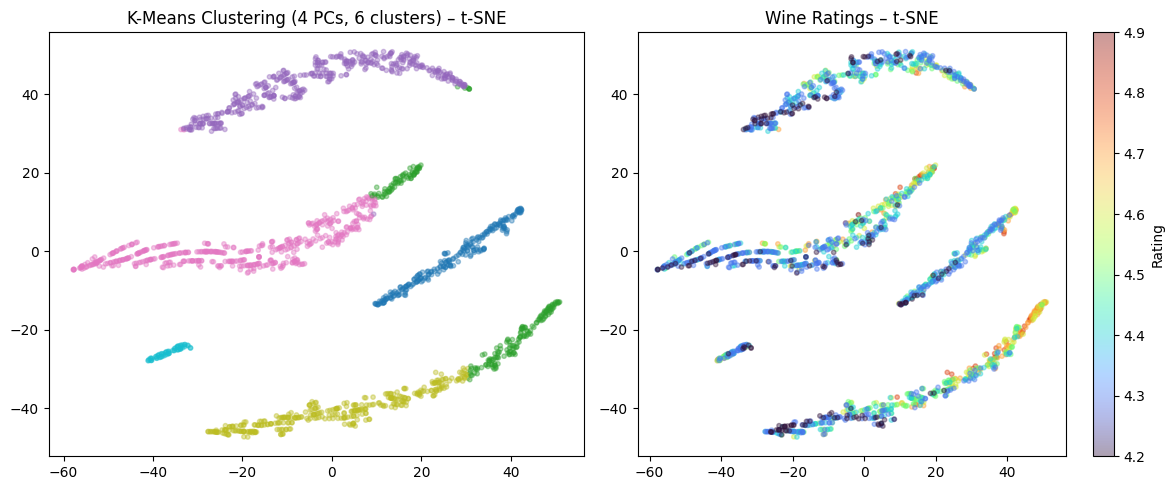

In [128]:
# I'm creating a t-SNE plot with wine ratings as color coding for the PCA data, and putting it next to the t-SNE plot with KMeans clustering labels above.  
# PCA plot and t-SNE plots with KMeans clustering labels
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot k-Means clustering results
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='tab10', s=10, alpha=0.4)     
axes[0].set_title('K-Means Clustering (4 PCs, 6 clusters) – t-SNE')

# Plot wine ratings and store the scatter object
scatter = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['rating'], cmap='turbo', s=10, alpha=0.4)     
axes[1].set_title('Wine Ratings – t-SNE')

# Add colorbar correctly using the stored scatter plot
fig.colorbar(scatter, ax=axes[1], label='Rating')

plt.tight_layout()
plt.show()

**Observations:**  

The clustering looks cleaner than in the original 6 feature version (see above). That corresponds with the slightly better silhouette score. However, for the wine rankings, I am a bit lost. I'm not sure what to say other than it doesn't fit very well. 

### 6. Supervised classifier trained + confusion matrix

In [ ]:
# I am now adding the labels as a new column to the dataframe



df['kmeans_labels'] = kmeans_labels
# Now I am training logistic regression to predict the cluster labels based on the original features

X = df[feature_columns_sfs_mae]
y = df['kmeans_labels']

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
log_reg.fit(X_train, y_train)
# Predict on test set
y_pred = log_reg.predict(X_test)

# Evaluate model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Out of curiosity I want to know the correlation between the cluster labels and the wine ratings
correlation = df['kmeans_labels'].corr(df['rating'])
print(f"\nCorrelation between cluster labels and wine ratings: {correlation}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      0.98      0.99        44
           2       0.99      0.99      0.99        86
           3       0.99      1.00      0.99        99
           4       1.00      1.00      1.00        69
           5       1.00      1.00      1.00        12

    accuracy                           0.99       355
   macro avg       1.00      0.99      1.00       355
weighted avg       0.99      0.99      0.99       355

[[45  0  0  0  0  0]
 [ 0 43  1  0  0  0]
 [ 0  0 85  1  0  0]
 [ 0  0  0 99  0  0]
 [ 0  0  0  0 69  0]
 [ 0  0  0  0  0 12]]

Correlation between cluster labels and wine ratings: -0.17754460180448492


**Observations:**  

The results are almost perfect. It seems the clustering has been successful in the sense as cluster classes are now predicatble with logistic regression. That's important because otherwise I can only describe data with clustering, but not apply this knowledge to new data. 

I have neither scaled the data for this training, nor have I used the PCA data (although the labels were based on both). I still get good result. I'm not sure if this is by accident or if this is always the case. I should probably stay on the safe side and create a pipeline to always have the same conditions. 

Completely unrelated, the correlation of the clusters with the wine ratings is quite low, as expected. I'm not sure why I used wine ratings at all in this sheet. 

### 7. Comparative discussion (unsupervised vs supervised)

In [130]:
# Not sure what to code here

**Observations:**  

Unsupervised learning feels very different than supervised learning. 

When doing supervised learning, it is intuitively clear that there is very likely no perfect prediction. (Probably because I have a regression line in front of my eyes.)

However, for unsupervised learning, it feels strange that a better clustering should not be possible. I suppose that is because we only have 2D visualisations, and while the clusters look so well seperated in there, the plots are just simplifications and do not show the real state. 

The other observation is that in order to predict clusters for unseen data, we need to train a supervised model with the obtained clusters. That wasn't so clear to me before. While models that are supervised initially can be used directly for predicting unseen data. 

Finally, it is still unfamiliar for me that we can create classes without having an interpretation what they mean. I would love to see more applications, in particular for anomalie detection. 



### 7. Perform cross validation and statistical techniques (advanced)

In [131]:
# ---- Your code here ----

**Observations:**  

I feel I covered this in the feature selection section (1a) with SFS.